#  Project Report - Predicting Heart Disease
Group Members: Chengyuan Yao, Eunji Hwang, Lina Anwari, Duffy Du
## Table of Contents:
1. [Introduction](#introduction)
2. [Methods](#methods)
3. [Results](#results)
4. [Discussion](#discussion)
5. [References](#references)


## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 1.0 Introduction <a id='introduction'></a>

**Background**  
Cardiovascular disease is one of the leading causes of death globally. This disease, also known as heart disease, is linked to several factors such as high cholesterol levels (Calling, 2021), obesity, smoking, and numerous more. To diagnose this disease, a person is tested with stress tests, blood tests, and more to find signs of heart disease to be diagnosed rightfully. 

Using the Heart Disease Data Set, we will be exploring relationships between numerical variables such as age, resting blood pressure, serum cholesterol, maximum heart rate, and ST depression induced by exercise to predict diagnosis. 


**Our Question**  
Based on patients’ vital signs and physiological observations, can we accurately predict whether they have heart disease?

**Variables/Descriptions:**
       
|Variables    |Descriptions    | 
| ------ | ------ |
| age |  age in years|
| trestbps | resting blood pressure (mm Hg)|
| chol | serum cholesterol (mg/dl) |
| thalach  | maximum heart rate (bpm) |
| oldpeak | Slope of ST depression induced by exercise |

<center><i>Table 1.1: The description of the meaning of different variables in this dataset</i></center>

**Our Dataset**  
For our classification model, the database we are using is the Heart Disease Data Set. Specifically, we will be analyzing the Cleveland database, which contains information collected by Robert Detrano (M.D., Ph D.) from the Medical Center, Cleveland Clinic Foundation. The data is based on anonymous real-life patients’ records. Each row represents observations of a different patient based on the 14 categories being tested, including the predicted attribute. Using this dataset, we can identify a relationship between predictors and the target variable to determine whether a patient has heart disease.  



## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.0 Methods <a id='methods'></a>


### Outline
We will first transform the dataset of heart disease patients into a tidy dataset with only the poteitnal numerical predictors and our exploratory variable as presence or absence of heart disease in a patient.  Next, we will explore all subsets of predictors to determine which subset of predictors produce the best accuracy score, which will be used for our final model. To answer our predictive question, we will train a KNN classification model with the chosen subset of predictors and predict the heart disease diagnosis for new patients in our testing set.

### 2.1 Importing Data
We first load the libraries used for this project and set the seed number(1234) to use for this project so that our code is reproducible.

In [1]:
# Loaded Libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
install.packages("expss")
library(expss)
library(ggplot2)
library(GGally)
library("gridExtra")



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [58]:
# set seed number for the project
seed_num <- 2

We use the following code to import our dataset from the web by URL link and convert the variables we want to classify (num) as a factor variable:

In [59]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", 
                                         "sex", 
                                         "cp", 
                                         "trestbps", 
                                         "chol", 
                                         "fbs", 
                                         "restercg", 
                                         "thalach", 
                                         "exang", 
                                         "oldpeak", 
                                         "slope", 
                                         "ca", 
                                         "thal", 
                                         "num"))
cleveland_data$num <- as.factor(cleveland_data$num)
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restercg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


<i>Table 2.1: An overview of the Cleveland Heart Disease Patient Dataset</i>

The num variable that represents heart disease diagnosis came in numbers of 0 to 4; we first check if this is true and then transform num from 0-4 to absent (num = 0) or present (num = 1, 2, 3, 4) and store into a diagnosis variable (only have two categories in this column which are absent and present).

In [60]:
# see if there is other number rather than 0-4 in the num column
cleveland_data  %>%
    select(num)  %>% 
    unlist() %>% 
    levels()


[1] "0" "1" "2" "3" "4"

In [61]:
# transform num from 0-4 to 0 or 1 (1, 2, 3, 4) and store into diagnosis variable
cleveland_data <- cleveland_data %>%
                  mutate(diagnosis = dplyr::recode(num, '0' = 'absent', .default = 'present'))
head(cleveland_data)

age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,present
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,present
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,absent


<i>Table 2.2: Cleveland Heart Disease Patient Dataset with a diagnosis column</i>

Then we see if the data is balanced in both categories (absent vs. present).

In [62]:
# to see how the original data distribute
cleveland_data %>% 
    group_by(diagnosis) %>%
    summarize(n = n())


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
absent,164
present,139


<i>Table 2.3: Distribution of patients with and without a heart disease diagnosis in the Cleveland Heart Disease Dataset</i>

Our data seem to be relatively balanced.

## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.2 Tidy and explore the data

We select all the numerical variables as potential predictors and the diagnosis variable as our exploratory variables.

In [63]:
# We select all the numerical columns and diagnosis column
cleveland_data2 <- cleveland_data%>%
            select(age, trestbps, chol, thalach, oldpeak, diagnosis)
head(cleveland_data2)

age,trestbps,chol,thalach,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,absent
67,160,286,108,1.5,present
67,120,229,129,2.6,present
37,130,250,187,3.5,absent
41,130,204,172,1.4,absent
56,120,236,178,0.8,absent


<i>Table 2.4: An overview of the tidied Cleveland Heart Disease Patient Dataset</i>

We split the heart disease dataset into testing and training sets by a 75/25 split. We decided that this split ratio allowed for enough observations to be used to train our model while still having enough observations in our test set to evaluate its accuracy.

In [64]:
# split the data into trainning and testing (ratio = 3:1)
set.seed(seed_num) 
heart_split <- initial_split(cleveland_data2, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

We made a summary table to see the overall trend of our data after tidiness.

In [65]:
# Summary statistics (max, min, mean, median and SD) of numerical variables
summary_data <-heart_train %>%
                apply_labels(age= "age",
                            trestbps = "trestbps",
                            chol = "chol",
                            thalach = "thalach",
                            oldpeak = "oldpeak")
                             
summary_table <- summary_data %>%
                 tab_cells(age, trestbps, chol, thalach, oldpeak) %>%
                 tab_cols(total(label = "Summary Statistics(table1.2)"))  %>%
                 tab_stat_fun(Max = w_max, Min = w_min, Mean = w_mean, "Median" = w_median, "Standand Deviation " = w_sd, method = list) %>%
                tab_pivot()
summary_table

|          | Summary Statistics(table1.2) |     |       |        |                     |
 |          |                          Max | Min |  Mean | Median | Standand Deviation  |
 | -------- | ---------------------------- | --- | ----- | ------ | ------------------- |
 |      age |                         77.0 |  29 |  54.8 |   56.0 |                 9.2 |
 | trestbps |                        200.0 |  94 | 132.2 |  130.0 |                18.2 |
 |     chol |                        564.0 | 131 | 248.2 |  243.0 |                52.9 |
 |  thalach |                        202.0 |  71 | 148.7 |  151.0 |                22.8 |
 |  oldpeak |                          6.2 |   0 |   1.1 |    0.8 |                 1.2 |

*Table 2.5: The summary statistics (max, min, mean, median and SD) of all potential predictors that we will use*

##  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3 Preliminary Exploratory Graphs and Analysis
 

We use two standards to choose predictors:
1) independent from other explanatory variables.

2) related to the responsible variable. 

The first standard avoids collinearity which decreases the predictive power of the model. For the second standard, we only choose the explanatory variables that are related to the responsible variable to ensure all predictors will contribute sufficiently significant predictive power to our model, which maintains a balance between accuracy and simplicity

###  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.1 Graphs of Explanatory Variables Versus Each Other <a id='exp-exp'></a>

We use the **ggpairs** function to plot the different distribution of different variables and let color equal to diagnosis. Combining graphs of all selected variables in our data would give us a prior understanding of the relationships.

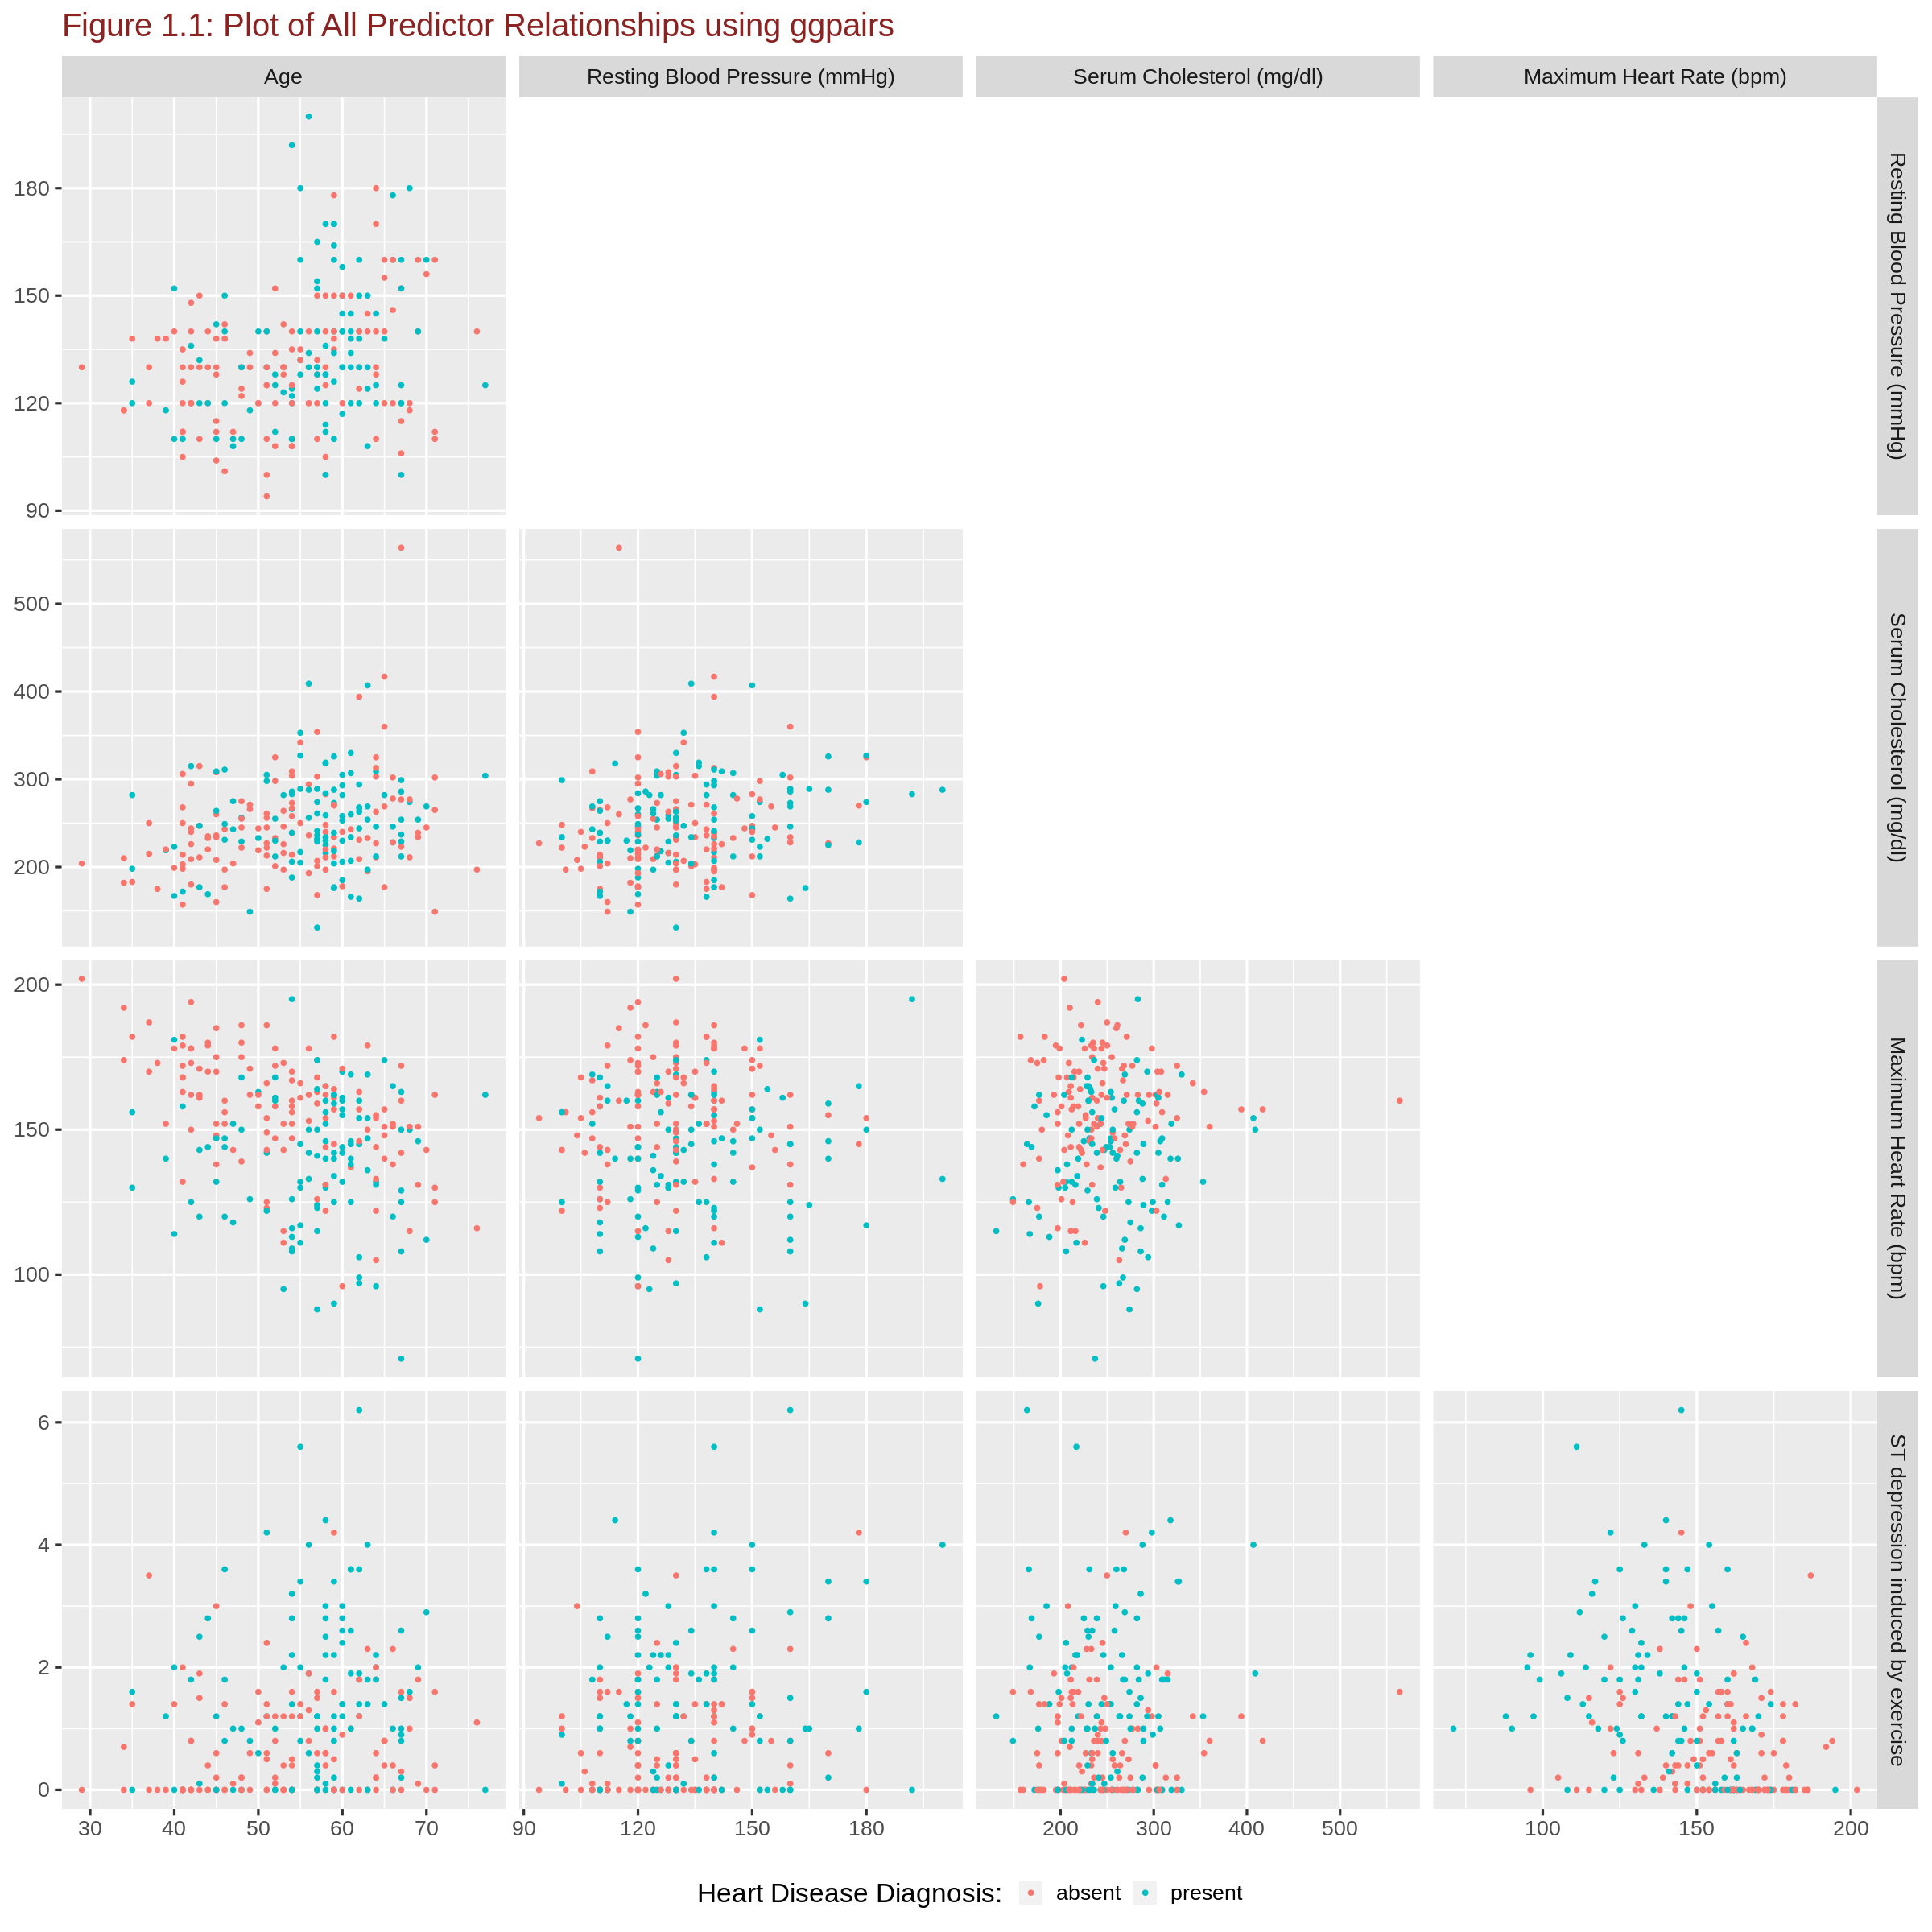

In [66]:
options(repr.plot.width = 20, repr.plot.height = 20) 

plot_pairs <- heart_train %>% 
  select(age, trestbps, chol, thalach, oldpeak, diagnosis) %>%
  ggpairs(legend = 6,
          columns = 1:5,
          mapping = ggplot2::aes(color = diagnosis),
          columnLabels = c("Age", "Resting Blood Pressure (mmHg)", "Serum Cholesterol (mg/dl)", "Maximum Heart Rate (bpm)", "ST depression induced by exercise"),
          diag = NULL,
          upper = "blank"
          ) +
          labs(color = "Heart Disease Diagnosis: ") +
          theme(axis.text.x = element_text(hjust = 1, color = "black", size = 20),
                axis.text.y = element_text(hjust = 1, color = "black", size = 20)) +
          theme_grey(base_size = 20)+
          theme(legend.position = "bottom")+
          labs(title = "Figure 1.1: Plot of All Predictor Relationships using ggpairs")+
         theme(plot.title = element_text(color = "brown4"))


# function to remove top most and right most row/column
gpairs_lower <- function(g){
  g$plots <- g$plots[-(1:g$nrow)]
  g$yAxisLabels <- g$yAxisLabels[-1]
  g$nrow <- g$nrow -1

  g$plots <- g$plots[-(seq(g$ncol, length(g$plots), by = g$ncol))]
  g$xAxisLabels <- g$xAxisLabels[-g$ncol]
  g$ncol <- g$ncol - 1

  g
}

gpairs_lower(plot_pairs)

<center><i>Figure 1.1: Plot of All Predictor Relationships using ggpairs</i></center>

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2 Explanatory Variables vs. Heart Disease Diagnosis<a id='var-diag'></a>

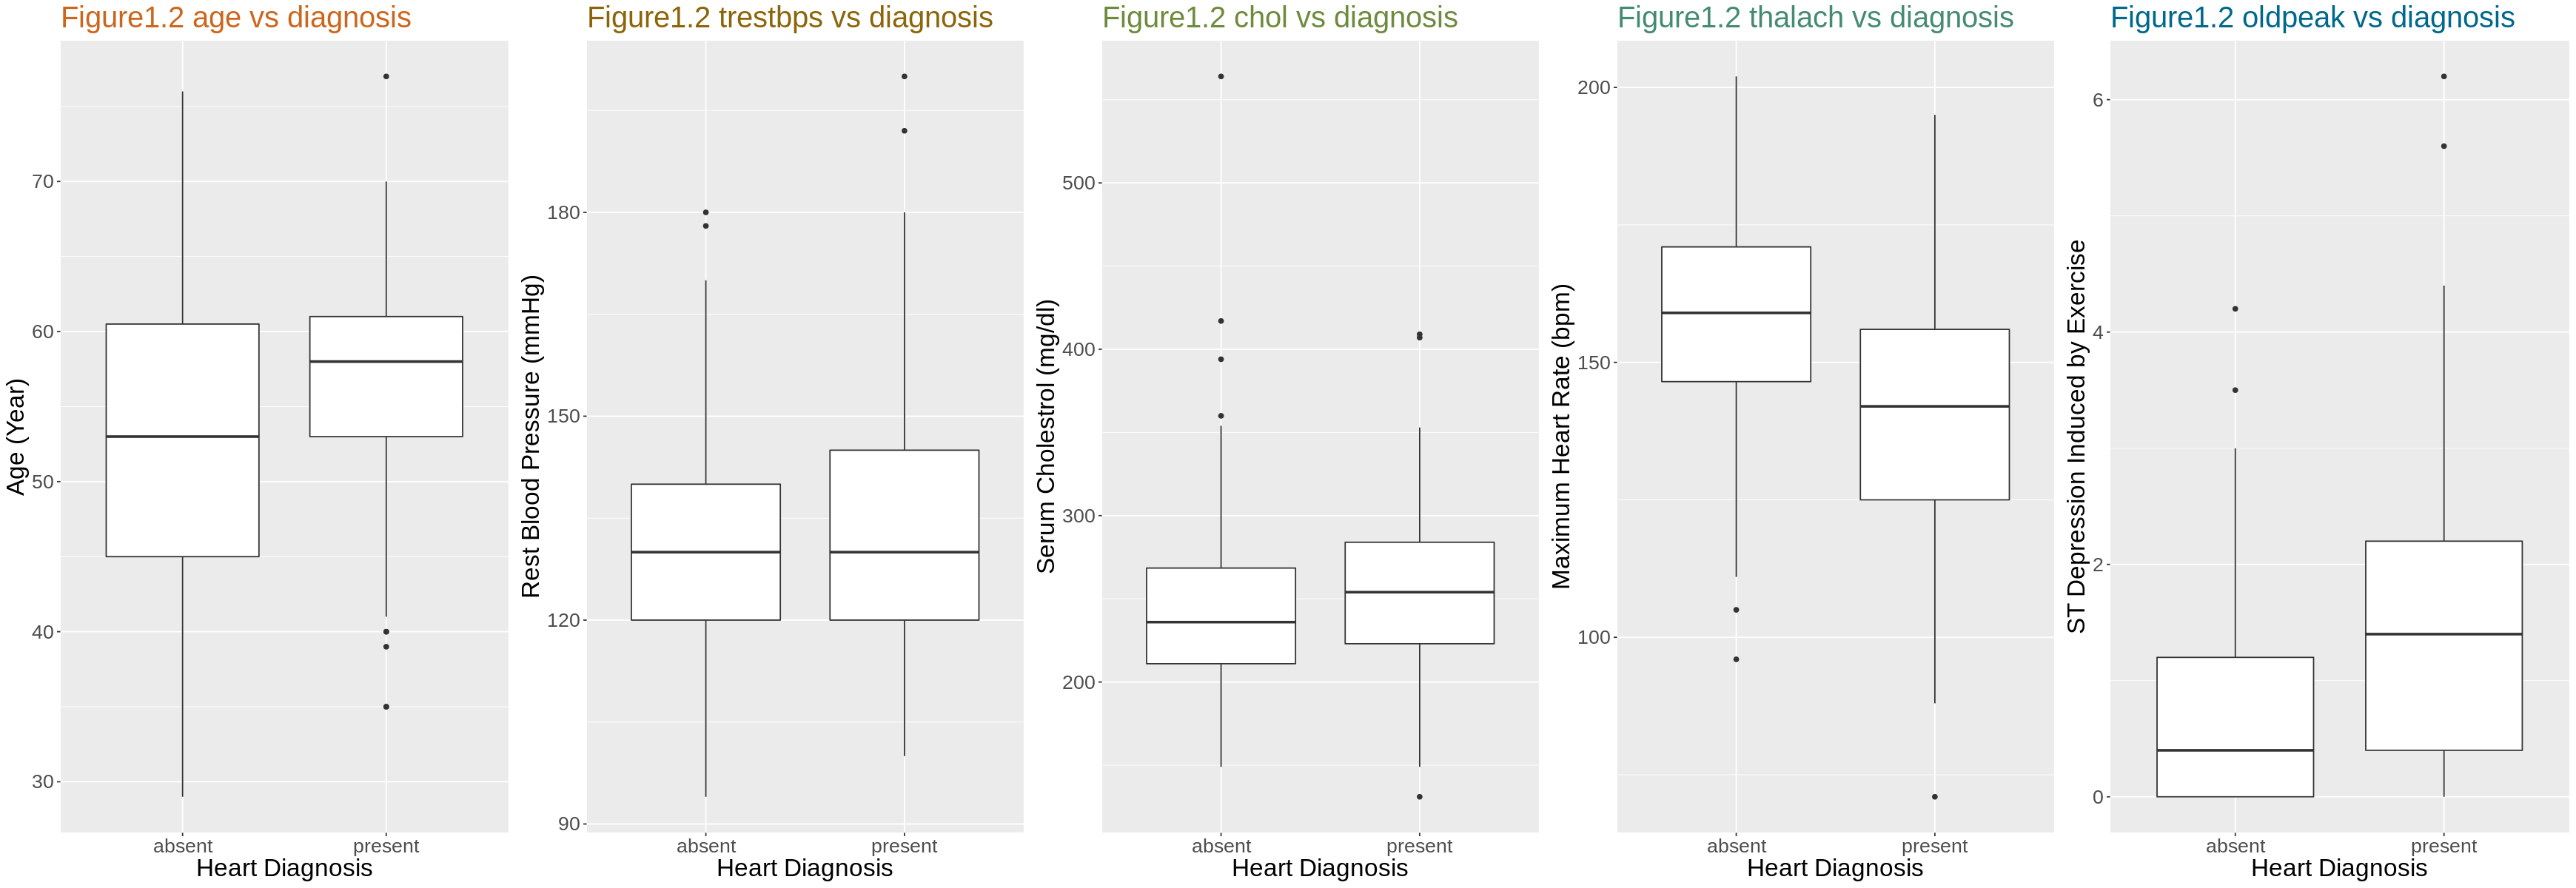

In [67]:
# age, trestbps, chol, thalach, oldpeak vs diagnosis

options(repr.plot.width = 29, repr.plot.height = 10)

age_diag_plot <- ggplot(heart_train,aes(y=age,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Age (Year)") +
    theme(text=element_text(size=20))+      
    labs(title = "Figure1.2 age vs diagnosis ")+
    theme(plot.title = element_text(color = "chocolate3"))



trestbps_diag_plot <- ggplot(heart_train,aes(y=trestbps,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Rest Blood Pressure (mmHg)") +
    theme(text=element_text(size=20))+          
    labs(title = "Figure1.2 trestbps vs diagnosis ")+
    theme(plot.title = element_text(color = "darkgoldenrod4"))


chol_diag_plot <- ggplot(heart_train,aes(y=chol,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Serum Cholestrol (mg/dl)") +
    theme(text=element_text(size=20))+
    labs(title = "Figure1.2 chol vs diagnosis ")+
    theme(plot.title = element_text(color = "darkolivegreen4"))


thalach_diag_plot <- ggplot(heart_train,aes(y=thalach,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Maximum Heart Rate (bpm)") +
    theme(text=element_text(size=20)) +                    
    labs(title = "Figure1.2 thalach vs diagnosis ")+
    theme(plot.title = element_text(color = "aquamarine4"))


oldpeak_diag_plot <- ggplot(heart_train,aes(y=oldpeak,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="ST Depression Induced by Exercise")+
    theme(text=element_text(size=20))+
    labs(title = "Figure1.2 oldpeak vs diagnosis ")+
    theme(plot.title = element_text(color = "deepskyblue4"))

combined_diag_plot <- grid.arrange(age_diag_plot,trestbps_diag_plot,chol_diag_plot,thalach_diag_plot,oldpeak_diag_plot, ncol = 5)
         


*Figure 1.2: Box plots of distribution of age, resting blood pressure, serum cholesterol, maximum heart rate, ST depression induced by exercise in patients with/without heart disease diagnosis*

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.3 Analysis of Graphs<a id='analysis'></a>

In Figure 1.1, no strong relationships are seen between any two explanatory variables, so all explanatory variables meet the standard. In 1.2, as the presence of heart disease varies, the distribution of each variable is significantly different, which means all explanatory variables are related to the responsible variable. Therefore, all of the explanatory variables are chosen as potential predictors in our exploratory step.

## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/>2.4 Tuning the Classifier

In order to build our classification model, we first find the subset of predictors that give the highest accuracy on our training dataset, then we use functions in the tidymodel package to determine the best value for the parameter k using the chosen predictors.

### 2.4.1 Chosing the predictors in a Systematic Way

We first store all 31 possible combinations of predictors into `ps_predictors` using a powerset function on the set of predictors.

In [68]:
set.seed(seed_num)
set_of_predictors <- c("age","trestbps","chol","thalach","oldpeak")

ps_predictors <- is.element("age",set_of_predictors)

powerset <- function(set) {
    ps <- list()
    set_length <- length(set)
    while (length(ps) < 2 ^ set_length - 1) {
        for(i in 1:set_length) {
            sample_i <- as.list(sample(set,i))
            t <- FALSE
            for(x in ps) {
                if(setequal(sample_i,x)) {
                   t <- TRUE
                }
            }
            if (t != TRUE) {
                ps <- append(ps,list(sample_i))
            }
        }
    }
    return(ps)
}

ps_predictors <- powerset(set_of_predictors)

ps_predictors #All combinations of the predictors



[[1]]
[[1]][[1]]
[1] "oldpeak"


[[2]]
[[2]][[1]]
[1] "age"

[[2]][[2]]
[1] "oldpeak"


[[3]]
[[3]][[1]]
[1] "age"

[[3]][[2]]
[1] "thalach"

[[3]][[3]]
[1] "oldpeak"


[[4]]
[[4]][[1]]
[1] "age"

[[4]][[2]]
[1] "trestbps"

[[4]][[3]]
[1] "chol"

[[4]][[4]]
[1] "oldpeak"


[[5]]
[[5]][[1]]
[1] "chol"

[[5]][[2]]
[1] "trestbps"

[[5]][[3]]
[1] "thalach"

[[5]][[4]]
[1] "age"

[[5]][[5]]
[1] "oldpeak"


[[6]]
[[6]][[1]]
[1] "age"


[[7]]
[[7]][[1]]
[1] "age"

[[7]][[2]]
[1] "thalach"


[[8]]
[[8]][[1]]
[1] "thalach"

[[8]][[2]]
[1] "chol"

[[8]][[3]]
[1] "trestbps"


[[9]]
[[9]][[1]]
[1] "age"

[[9]][[2]]
[1] "trestbps"

[[9]][[3]]
[1] "oldpeak"

[[9]][[4]]
[1] "thalach"


[[10]]
[[10]][[1]]
[1] "trestbps"

[[10]][[2]]
[1] "chol"


[[11]]
[[11]][[1]]
[1] "age"

[[11]][[2]]
[1] "chol"

[[11]][[3]]
[1] "oldpeak"

[[11]][[4]]
[1] "thalach"


[[12]]
[[12]][[1]]
[1] "thalach"

[[12]][[2]]
[1] "trestbps"


[[13]]
[[13]][[1]]
[1] "oldpeak"

[[13]][[2]]
[1] "trestbps"

[[13]][[3]]
[1] "age"


[[14]]
[[14]][[1]]
[1] "trestbps"

[[14]][[2]]
[1] "oldpeak"

[[14]][[3]]
[1] "chol"

[[14]][[4]]
[1] "thalach"


[[15]]
[[15]][[1]]
[1] "trestbps"


[[16]]
[[16]][[1]]
[1] "chol"

[[16]][[2]]
[1] "oldpeak"


[[17]]
[[17]][[1]]
[1] "oldpeak"

[[17]][[2]]
[1] "chol"

[[17]][[3]]
[1] "trestbps"


[[18]]
[[18]][[1]]
[1] "age"

[[18]][[2]]
[1] "thalach"

[[18]][[3]]
[1] "chol"


[[19]]
[[19]][[1]]
[1] "thalach"


[[20]]
[[20]][[1]]
[1] "trestbps"

[[20]][[2]]
[1] "age"

[[20]][[3]]
[1] "chol"


[[21]]
[[21]][[1]]
[1] "chol"


[[22]]
[[22]][[1]]
[1] "oldpeak"

[[22]][[2]]
[1] "thalach"


[[23]]
[[23]][[1]]
[1] "oldpeak"

[[23]][[2]]
[1] "chol"

[[23]][[3]]
[1] "age"


[[24]]
[[24]][[1]]
[1] "chol"

[[24]][[2]]
[1] "age"


[[25]]
[[25]][[1]]
[1] "age"

[[25]][[2]]
[1] "thalach"

[[25]][[3]]
[1] "trestbps"

[[25]][[4]]
[1] "chol"


[[26]]
[[26]][[1]]
[1] "trestbps"

[[26]][[2]]
[1] "age"


[[27]]
[[27]][[1]]
[1] "thalach"

[[27]][[2]]
[1] "oldpeak"

[[27]][[3]]
[1] "chol"


[[28]]
[[28]][[1]]
[1] "oldpeak"

[[28]][[2]]
[1] "trestbps"


[[29]]
[[29]][[1]]
[1] "chol"

[[29]][[2]]
[1] "thalach"


[[30]]
[[30]][[1]]
[1] "oldpeak"

[[30]][[2]]
[1] "trestbps"

[[30]][[3]]
[1] "thalach"


[[31]]
[[31]][[1]]
[1] "trestbps"

[[31]][[2]]
[1] "thalach"

[[31]][[3]]
[1] "age"

We will use KNN classification for *all possible combination of predictors* with heart disease diagnosis as the exploratory variable. A for loop is used to run the 10-fold cross validation, k value tuning and accuracy calculations on each combination. 

Within each for loop iteration:
- We assign the tune() function to the parameter value k in the knn classification model specification we'll use for tuning. 
- Then we set up a range of 1 -23 to test wich is the best value for k in this range, so we plot the accuracy values against k values to find the most optimal value for the parameter k. The k value range was chosen because the maximum number of data points in each fold after the 10-fold corss validation is 23.
- In a workflow, we connect our model specification with the scaling formula that was previously defined. Then, the tune grid function fits the model to each value in our parameter range.
- We then use the optimal k value for that subset of predictors to train the model with the training set and test its accuracy on the validation set.

In the end, the result is displayed in a table with 3 columns: predictor, best k value (as chosen through 10-fold cross validation), and accuracy score.

<span style="color:red"><strong>Warning! The following block of code might take some time to run.</strong></span>

In [69]:
set.seed(seed_num) 
# Perform 10 folds Cross-Validation for heart_train dataset
heart_10fold <- vfold_cv(heart_train, v=10, strata = diagnosis)

# KNN classification model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# define range of k values to be 1-23 (maximum 23 data points in each fold)
gridvals <- tibble(neighbors = seq(from = 1, to = 23))

# lists storing formulas for predictor combinations, k-values, and accuracies
Formula <- c()
K_value <- c()
Accuracy <- c()

# calcaulate accuracy scores on every single combination
for (combination in ps_predictors) {
    # generating formula for the current combination
    y <- "diagnosis ~"
    x <- combination[[1]]
    i <- 1
    while(i < length(combination)) {
        x <- paste(x, combination[[i+1]], sep = " + ") 
        i = i + 1
    }
    heart_formula <- as.formula(paste(y,x))
    
    
    # knn recipe initialization with the current combination
    knn_recipe <- recipe(heart_formula, data = heart_train) %>% 
            step_center(all_predictors()) %>%
            step_scale(all_predictors())
    
    # workflow
    heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)
    
    # results
    heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 
    
    # filter for accuracy
    accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 
    
    
    # look for the k value with the best accuracy score
    appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()
    
    
    # new knn specification with the chosen k value
    knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")
    
    # fit model onto training set
    heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)
    
    # predict on testing set
    heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)
    
    # prediction metrics calculation
    heart_metrics <- heart_predictions %>% 
                    metrics(truth = diagnosis, estimate = .pred_class)
    
    # appending results to the appropriate lists
    Formula <- append(Formula,heart_formula)
    K_value <- append(K_value, appropriate_k)  
    accuracy_val <- heart_metrics %>%
                filter(.metric == "accuracy") %>%
                select(.estimate) %>%
                pull()
    Accuracy <- append(Accuracy,accuracy_val)
}

In [70]:
# Putting results into a table format (formula, k-value, Accuracy)
Formula <- as.character(Formula)
All_info <- data.frame(Formula, K_value, Accuracy) %>%
            arrange(-Accuracy)
head(All_info)

# find the combination of predictors with the highest accuracy score
selected_predictors <- All_info %>%
                slice(1)
selected_predictors


,Formula,K_value,Accuracy
,<chr>,<int>,<dbl>
1,diagnosis ~ age + trestbps + oldpeak + thalach,23,0.8266667
2,diagnosis ~ oldpeak + trestbps + thalach,19,0.8266667
3,diagnosis ~ chol + trestbps + thalach + age + oldpeak,23,0.8000000
4,diagnosis ~ oldpeak + thalach,23,0.8000000
5,diagnosis ~ age + thalach + oldpeak,17,0.7866667
6,diagnosis ~ oldpeak,13,0.7733333


Formula,K_value,Accuracy
<chr>,<int>,<dbl>
diagnosis ~ age + trestbps + oldpeak + thalach,23,0.8266667


*Table 2.6: Table of predictor combinations with their respective KNN classification model's optimal k-value and accuracy score*

As we can see from the results, the combination of predictors that gave the greatest accuracy is using all five of the predictors. Therefore, all five variables are chosen as the final predictors that we will use for our final KNN classification model.

## 2.5 Using the Model

As the result above shown that the model could get the highest accuracy would be :

**A KNN-classification model with thalach, trestbps, age, and oldpeak as the predictors with k value equals 9.**


### 2.5 Plot of Accuracy vs. K values
We start by assigning the tune() function to the parameter value k in the knn classification model specification we'll use for tuning. Then we set up a range of 1-23 to test wich is the best value for k in this range, so we plot the accuracy values against k values to find the most optimal value for the parameter k.  

In a workflow, we connect our model specification with the recipe that was previously defined. Then, the tune grid function fits the model to each value in our parameter range.

In [72]:
knn_recipe <- recipe(diagnosis ~ age + trestbps + oldpeak + thalach, data = heart_train) %>%
            step_center(all_predictors()) %>%
            step_scale(all_predictors())

heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)

gridvals <- tibble(neighbors = seq(from = 1, to = 23))

heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 

accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 

We graph the accuracy estimate against K values (neighbours).

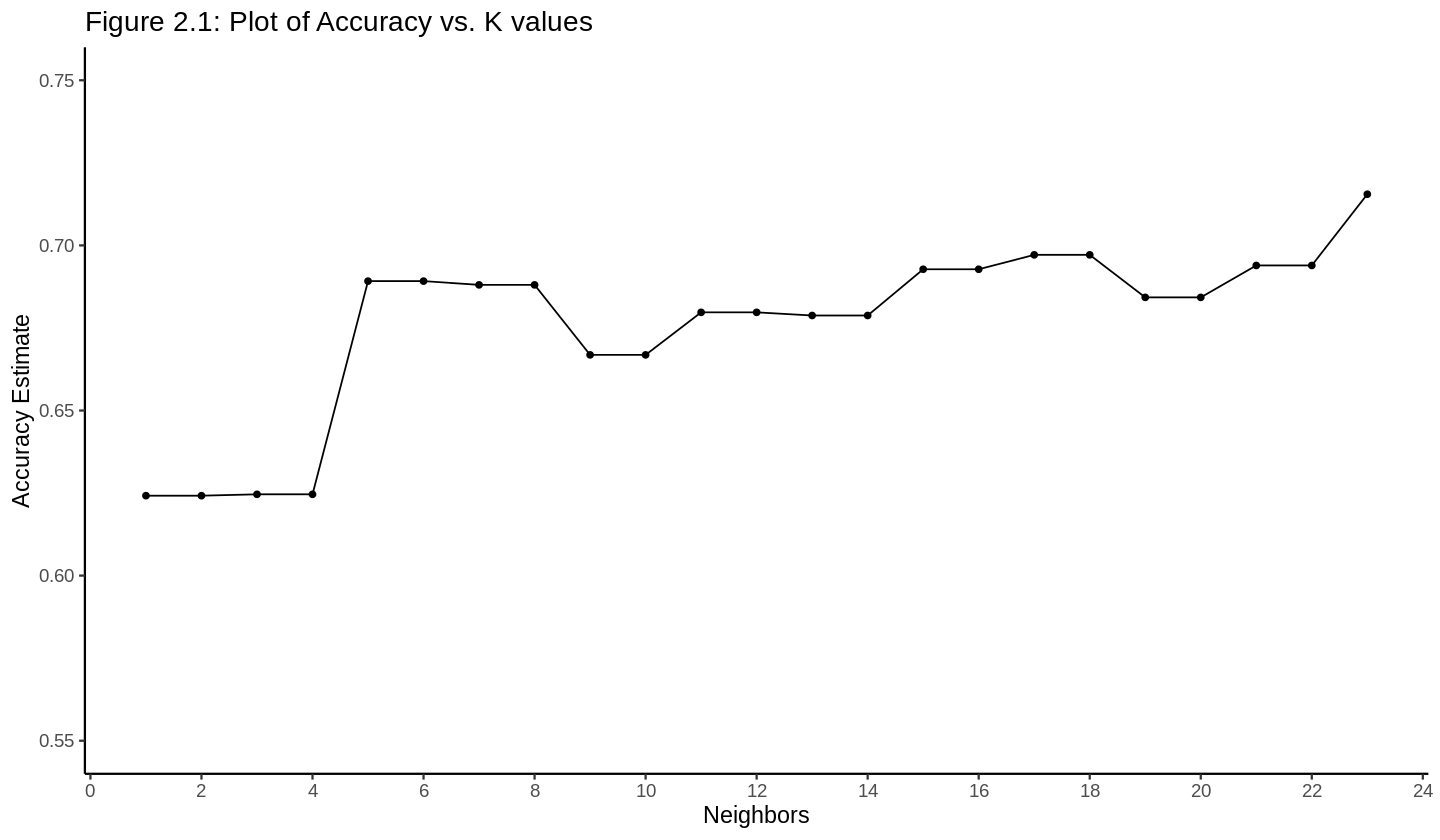

In [73]:
options(repr.plot.width=12, repr.plot.height=7)
# accuracy
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 40, by = 2)) + # adjusting the x-axis
       scale_y_continuous(limits = c(0.55, 0.75)) + # adjusting the y-axis 
       theme(text=element_text(size = 20)) +
       theme_classic(base_size = 14)+
       ggtitle ("Figure 2.1: Plot of Accuracy vs. K values")

accuracy_versus_k


We extract the number of neighbors associated with the highest accuracy estimate and save that value as appropriate_k. We can also visually see that the accuracy of the model peaks around K = 23 which provides a high accuracy model.

In [74]:
appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()
appropriate_k


[1] 23

### 2.6 Training the Classifier
Next, we create our final model specification using `appropriate_k` (K = 23) as the number of nearest neighbors and fit the model to our training set to create our finalized classifier.

In [79]:
set.seed(seed_num)
# final model specification
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# workflow
heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)

### 2.7 Predicting the Testing Set
We use our finalized trained KNN classfication model to predict heart disease in patients in our testing set. We then bind the predictions produced by our model with the original testing set, so that we can compare our predictions to the true class values.

In [80]:
heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)
head(heart_predictions)


.pred_class,age,trestbps,chol,thalach,oldpeak,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
absent,41,130,204,172,1.4,absent
present,53,140,203,155,3.1,present
absent,57,140,192,148,0.4,absent
absent,44,120,263,173,0.0,absent
absent,52,172,199,162,0.5,absent
present,58,132,224,173,3.2,present


## 3.0 Results <a id='results'></a>
Comparing the predictions of our KNN classfication model on the testing data to the actual value, we can evaluate our model's performance by calculating the overall accuracy of our model's predictions. We achieve a final accuracy rate of 82.67 %.

In [82]:
heart_summary <- heart_predictions %>%
                  metrics(truth = diagnosis, estimate = .pred_class) %>%
                  filter(.metric == "accuracy")

heart_accuracy <- heart_summary %>%
                select(.estimate) %>%
                pull()

paste(round(heart_accuracy*100,2), "%")


[1] "82.67 %"

We also put the prediction results into a confusion matrix comparing with the actual results, this allow us to see how many false positives and false negatives our models gave.

In [83]:
heart_conf_mat <- heart_predictions %>%
    conf_mat(truth = diagnosis, estimate = .pred_class)

heart_conf_mat

          Truth
Prediction absent present
   absent      39      11
   present      2      23

Our model gave 2 false positives and 11 false negatives. This might not be a very good model to use in a medical field as false negatives may lead to a misdiagnosis of heart disease and patient will not be treated in time for their condition. However, our model produced a relatively low number of false positives. This could be good in a medical perspective in that if a patient tests positive, there is a low chance that they don't have the condition and still have to go through additional invasive tests uneccessarily. 

To conclude with numbers, our model has a sensitivity of 67.64% (23/(23+11) = 67.64%) and a specificity of 95.12% (39/(39+2) = 95.12%).

## 4.0 Discussion <a id='discussion'></a>

After tidying our data, we trained our model to perform KNN classification and found the best value of K to be 9. Testing the accuracy scores of all combinations of our potential predictors, we found that using the combination of the four predictors: “ST depression induced by exercise relative to rest” (oldpeak), “maximum heart rate” (thalach), "age" (age), and "resting blood pressure" (trestbps), gave the highest accuracy. With these four predictors, we can confidently predict the presence of heart disease in patients in our testing data set with an accuracy score of 82.67 %.

According to previous research, ST depression caused after exercise is known to detect heart disease with a sensitivity of about 75% and a specificity of 64% (Bobbio et al., 1992). Our model has a sensitivity of 67.64% and a specificity of 95.12%. Although, it might not be as sensitive to the presence of heart disease in a patient as Bobbio's model, but it could potentially be used as a better screening tool to rule out heart disease using ST depression along with the other three predictors (maximum heart rate, resting blood pressure, and age) compared with using ST depression alone. Furthermore, after graphing maximum heart rate against the presence or absence of heart disease, we saw a trend that a lower maximum heart rate is a predictor of heart disease. With those results, we expected that maximum heart rate would be a predictor for diagnosis, which our model agrees with.  

Our model allows us to use age, resting blood pressure, maximum heart rate, ST depression as heart disease markers, which has the potential to benefit and save many lives. By understanding these predictors, we can potentially use them in the future for screening/diagnosing heart disease. Future questions may lead to ways of improving accuracy using these two predictors. For example, suppose this model is reproducible with larger datasets and has a high accuracy score. In that case, it can be a potential screening tool for heart disease patients before any invasive procedures for diagnosis. Additionally, future research can expand on genetic and environmental factors that influence the predictors for the presence of heart disease. It could also lead to questions that explore the prevention, allowing for more opportunities for healthier lifestyles.  

**Future questions this could lead to are:**  
1. What internal and external factors influence ST depression and maximum heart rate? 
2. Are there other variables within the Heart Disease dataset that are also predictors with good accuracy of heart disease?
3. In what ways can we prevent ST depression and low maximum heart rate? How effective are the methods of prevention?


## 5.0 References <a id='references'></a>
Abi-Mansour, P., Bobbio, Colombo, A., M., Deckers, J.W., Detrano, R., Guppy, K.H., Janosi, A., Lehmann, K.G., Olson, H.G., Pfisterer, M., Righetti, A., Schmid, J., Steinbrunn, W. (1992). Exercise-induced ST depression and ST/heart rate index to predict triple-vessel or left main coronary disease: A multicenter analysis. Journal of the American College of Cardiology, 19(1), 11-18. https://doi.org/10.1016/0735-1097(92)90044-N
 
Calling, S., Johansson, S. E., Sundquist, J., Sundquist, K., Wolff, M. (2021). Total cholesterol/HDL-C ratio versus non-HDL-C as predictors for ischemic heart disease: a 17-year follow-up study of women in southern Sweden. BMC cardiovascular disorders, 21(1), 163. https://doi.org/10.1186/s12872-021-01971-1
 
 
UCI Machine Learning Repository. (1988). Heart Disease Data Set [Data file]. Retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
